# Import Statements

In [68]:
import fitsio as fio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy
import collections
import pickle
import os.path

from skimage.feature import hog # Histogram of oriented gradients
from skimage import data, color, exposure, io

from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

from fits_corr import *
from fits_corr.libs.utils import * 

from random import shuffle

from astropy.table import Table, Column
%matplotlib inline


In [36]:
from bokeh.io import output_notebook, show, gridplot
from bokeh.models import ColumnDataSource, HoverTool, CustomJS
from bokeh.plotting import figure
from bokeh.layouts import row

output_notebook()

Loading BokehJS ...

# Constants

Define the variable **fits_data_loc** to be the directory on your computer which contains all fits files. 
The variable **folders** is specific to my storage of the fits files (downloaded into seperate folders).

In [49]:
# Location of FITS files on my computer (mine were stored in several folders, which I had to walk through)
fits_data_loc = "/Users/mulan/desktop/fits_data/"
folders = ['0004', '0006', '0008', '0010', '0012', '0014', '0016', '0018', '0020']
cdir = os.getcwd()

# Number of ON/OFF pairs being analyzed
NUM_PAIRS=47242

# List of ON/OFF pairs (names)
pairs = []

# List of indices to be plotted by lasso in Bokeh plot
inds = []

# Functions

In [45]:
def load_pairs():
    
    """ Loads in all on/off pairs to the variable
        pairs. Filters out any files of incorrect
        shape. """
    
    for s in folders:
        pairs.extend(filter(lambda (a,b): fitsio.read(a).shape[0] == 16, get_on_off_pairs('./fits_data/' + s)))
    
    print("We have " + str(len(pairs)) + " pairs to examine.")

def plot_index(ind):
    
    """ Plots the ON and OFF FITS file
        corresponding to the IND row of
        original dataframe, df. """
    
    name = name_plot[ind] # vs names
    on_plt = fio.read(fits_data_loc + name + ".fits")
    off_plt = fio.read(fits_data_loc + name + "_OFF.fits")
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)
    ax1.imshow(on_plt, aspect=15)
    ax1.set_adjustable('box-forced')
    ax1.set_title('ON image')
    ax2.imshow(off_plt, aspect=15)
    ax2.set_adjustable('box-forced')
    ax2.set_title('OFF image')
    f.suptitle(name) 
    
def pcc_table(li):
    
    """ Takes in LI, a list of indices, and
        outputs the correlation information
        of the index. Outputs only aligned
        information. """
    
    data_rows = []
    
    for l in li:
        name = name_plot[l]
        df1 = df_aligned.loc[name]
        data_rows.append(["{:0.2f}".format(x) for x in df1])
    t = Table(rows=data_rows, names=("a_freq_c", "a_global", "a_nmi", "a_prmi",
                                     "a_spatial", "a_ssim", "a_time_c"))
    print(t)
    
def hog_table(l=None):
    
    """ Depracated function. Only works on unshuffled
        data. Outputs a table of indices and the hog
        transformation for list L. If no list is
        supplied, then it takes the list from
        variable indices. Note that indices
        ending in .00 signify the ON signals and
        the indices ending in .50 signify the OFF
        signals. """
    
    data_rows = []
    
    if (l is None):
        for i in inds:
            a=np.insert(hog_fd[i][0],0,i)
            b=np.insert(hog_fd[i][1],0,i+0.5)
            data_rows.append(["{:0.2f}".format(x) for x in a])
            data_rows.append(["{:0.2f}".format(x) for x in b])
    else:
        for i in l:
            a=np.insert(hog_fd[i][0],0,i)
            b=np.insert(hog_fd[i][1],0,i+0.5)
            data_rows.append(["{:0.2f}".format(x) for x in a])
            data_rows.append(["{:0.2f}".format(x) for x in b])
    t = Table(rows=data_rows, names=("ind", "0-2.5", "2.5-45", "45-87.5", "87.5-92.5", "92.5-135", "135-177.5", "177.5-180"))
    
    print(t)
    
def plot_hog(lim=None):
             
    """ Plots the ON/OFF pair images as well as HOG
        versions of the ON/OFF pairs. Plots the first
        LIM pairs. Otherwise, all lassoed ON/OFF pairs
        will be plotted. """
    
    if lim is None:
        for x in inds:
            plot_index(x)
            fd1, hog_image_ON = hog(color.rgb2gray(open_fits(str(pairs[x][0]))), orientations=72, pixels_per_cell=(64, 16),
                            cells_per_block=(1, 1), visualise=True)
            fd2, hog_image_OFF = hog(color.rgb2gray(open_fits(str(pairs[x][1]))), orientations=72, pixels_per_cell=(64, 16),
                        cells_per_block=(1, 1), visualise=True)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

            ax1.imshow(hog_image_ON, aspect=15, cmap=plt.cm.gray)
            ax1.set_title('hog for ON image')
            ax1.set_adjustable('box-forced')

            ax2.imshow(hog_image_OFF, aspect=15, cmap=plt.cm.gray)
            ax2.set_title('hog for OFF image')
            ax2.set_adjustable('box-forced')
    else:
        for x in inds[:lim]:
            plot_index(x)
            fd1, hog_image_ON = hog(color.rgb2gray(open_fits(str(pairs[x][0]))), orientations=72, pixels_per_cell=(64, 16),
                            cells_per_block=(1, 1), visualise=True)
            fd2, hog_image_OFF = hog(color.rgb2gray(open_fits(str(pairs[x][1]))), orientations=72, pixels_per_cell=(64, 16),
                        cells_per_block=(1, 1), visualise=True)
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

            ax1.imshow(hog_image_ON, aspect=15)
            ax1.set_title('hog for ON image')
            ax1.set_adjustable('box-forced')

            ax2.imshow(hog_image_OFF, aspect=15)
            ax2.set_title('hog for OFF image')
            ax2.set_adjustable('box-forced')

# Loading in Data

In [20]:
load_pairs()

We have 47242 pairs to examine.


In [66]:
# An array containing the HOG processed data information; see LoadinginData.ipynb for more information
hog_fd = np.load('hog_image_64by16_72_wb_ed_p.npy')

hog_ON = np.array([x[0] for x in hog_fd])
hog_OFF = np.array([x[1] for x in hog_fd])

# To actually use the HOG information, we subtracted ON from OFF HOG vaules
hog_sub = abs(hog_ON - hog_OFF)

# An array containing header information of all files; see LoadinginData.ipynb for more information
header = np.load('header.npy')

# A dataframe containing ON/OFF pairs and their correlation values; see LoadinginData.ipynb for more information
df = pd.read_pickle("corr_pair.pkl")

# A dataframe containing ON/OFF pairs, their aligned correlation values, and some header info; see LoadinginData.ipynb for more information
df_mod = pd.read_pickle("mod_corr_dataframe.pkl")

# Subset of original dataframe containing only aligned correlation information 
df_aligned = df[['a_freq_c', 'a_global', 'a_nmi', 'a_prmi', 'a_spatial', 'a_ssim', 'a_time_c']]

# Array of names of all targets
names = df.index.values

In [23]:
# Below we convert header information into lists, to easily control the header information we want and do not want to use

# header_ON_FCNTR = [y[0] for y in [x[0] for x in header]]
header_ON_RA = [y[1] for y in [x[0] for x in header]]
header_ON_DEC = [y[2] for y in [x[0] for x in header]]
# header_ON_MJD = [y[3] for y in [x[0] for x in header]]

header_OFF_FCNTR = [y[0] for y in [x[1] for x in header]]
header_OFF_RA = [y[1] for y in [x[1] for x in header]]
header_OFF_DEC = [y[2] for y in [x[1] for x in header]]
# header_OFF_MJD = [y[3] for y in [x[1] for x in header]]

# Ended up deciding to take all the values for ON files; but just RA and DEC for OFF files
header_ON = [x[0] for x in header]
header_OFF = zip(header_OFF_RA, header_OFF_DEC)

header_info = [np.append(x, y) for x, y in zip(header_ON, header_OFF)]

# Statistics on Data

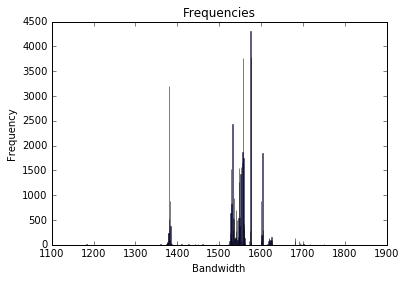

The next most common bandwidth is at 1575.0 mHz; with 4310 ON observations (9.12323779688%).
The next most common bandwidth is at 1576.0 mHz; with 3778 ON observations (7.99712120571%).
The next most common bandwidth is at 1557.0 mHz; with 3773 ON observations (7.98653740316%).
The next most common bandwidth is at 1381.0 mHz; with 3196 ON observations (6.76516658905%).
The next most common bandwidth is at 1532.0 mHz; with 2435 ON observations (5.15431184116%).
The next most common bandwidth is at 1556.0 mHz; with 1874 ON observations (3.96680919521%).
The next most common bandwidth is at 1604.0 mHz; with 1851 ON observations (3.91812370348%).
The next most common bandwidth is at 1558.0 mHz; with 1743 ON observations (3.68951356843%).
The next most common bandwidth is at 1554.0 mHz; with 1645 ON observations (3.48207103848%).
The next most common bandwidth is at 1552.0 mHz; with 1568 ON observations (3.31908047923%).
The next most common bandwidth is at 1548.0 mHz; with 1542 ON observat

In [70]:
frequencies = df_mod['freq'].tolist()
frequencies = [round(elem) for elem in frequencies]
counter = collections.Counter(frequencies)
 
freq = counter.keys()
performance = counter.values()
 
plt.bar(freq, performance, align='center', alpha=0.5)
plt.ylabel('Frequency')
plt.xlabel('Bandwidth')
plt.title('Frequencies')
 
plt.show()

common = counter.most_common()
least = [x for x in common if x[1] == 1]
least_names = map(lambda y: str(y), [x[0] for x in least])
for x in range(20):
    print("The next most common bandwidth is at " + str(common[x][0]) + " mHz; with " + str(common[x][1]) + " ON observations (" + str(common[x][1]/472.42) + "%).")
print("The least common bandwidths, with 1 ON observation, are: " + ", ".join([str(i) for i in least_names]))

So we don't want to filter out based on bandwidth. We'd lose a lot of data simply due to RFI assumption.
- 1381: GPS L3
- 1532: Immarsat
- 1556: Immarsat
- 1557: Immarsat
- 1558: Immarsat
- 1575: GPS L1
- 1576: GPS L1
- 1604: ??

# PCA

In [28]:
pca_vals_header = ['0-2.5; window0', '0-2.5; window1', '0-2.5; window2', '0-2.5; window3',
                   '0-2.5; window4', '0-2.5; window5', '0-2.5; window6', '0-2.5; window7',
                   '2.5-45', '45-87.5', '87.5-92.5', '92.5-135', '135-177.5',
                   '177.5-180; window0', '177.5-180; window1', '177.5-180; window2',
                   '177.5-180; window3', '177.5-180; window4', '177.5-180; window5',
                   '177.5-180; window6', '177.5-180; window7', 'ON_FCNTR', 'ON_RA',
                   'ON_DEC', 'ON_MJD', 'OFF_RA', 'OFF_DEC', 'a_freq_c', 'a_global',
                   'a_nmi', 'a_prmi', 'a_shift', 'a_spatial', 'a_ssim', 'a_time_c',
                   'u_freq_c', 'u_global', 'u_nmi', 'u_prmi', 'u_spatial', 'u_ssim',
                   'u_time_c']

pca_vals = ['0-2.5; window0', '0-2.5; window1', '0-2.5; window2', '0-2.5; window3',
            '0-2.5; window4', '0-2.5; window5', '0-2.5; window6', '0-2.5; window7',
            '2.5-45', '45-87.5', '87.5-92.5', '92.5-135', '135-177.5', '177.5-180; window0', 
            '177.5-180; window1', '177.5-180; window2', '177.5-180; window3',
            '177.5-180; window4', '177.5-180; window5', '177.5-180; window6',
            '177.5-180; window7', 'a_freq_c', 'a_global', 'a_nmi', 'a_prmi',
            'a_spatial', 'a_ssim', 'a_time_c']


no_header = [np.concatenate((y,z)) for y, z in zip(hog_sub, df_aligned.values)]
header = [np.concatenate((x,y,z)) for x, y, z in zip(hog_sub, header_info, df.values)]

pca_no_header = PCA(n_components=5, whiten=True, svd_solver = 'auto')
pca_no_header.fit(np.array(no_header))
pca_transform = pca_no_header.transform(no_header)
max_i = np.argmax(np.absolute(pca_no_header.components_[0]))

pca_header = PCA(n_components=5, whiten=True, svd_solver = 'auto')
pca_header.fit(np.array(header))
pca_header.transform(header)
max_i_h = np.argmax(np.absolute(pca_header.components_[0]))

print("pca w/o header:")
print(pca_no_header.explained_variance_ratio_)
print(pca_vals[max_i])
print("pca w/ header:")
print(pca_header.explained_variance_ratio_)
print(pca_vals_header[max_i_h])

pca w/o header:
[ 0.58394395  0.20007633  0.07775582  0.0430532   0.02345698]
a_freq_c
pca w/ header:
[  9.99995552e-01   4.31150707e-06   9.65503030e-08   3.99594329e-08
   2.31284231e-11]
OFF_RA


Notice that when we include header information, most of the variance (99%) is explained by one factor (OFF_RA), which is a pretty useless factor, so we'll throw it out.

# Plot

In terms of finding features to plot, I chose 2 approaches:
1. correlation values + HOG (shuffle_plot)
2. just the HOG values (fit_sub)

In [58]:
# Shuffle the data first
shuffled = zip(pca_transform, names)
shuffle(shuffled)
shuffle_plot = np.array([x[0] for x in shuffled])
name_plot = np.array([x[1] for x in shuffled])

# Feel free to play around with the below parameters to achieve better clustering
model = TSNE(n_components=2, random_state=0, perplexity=150, learning_rate=1000)
model_sub = TSNE(n_components=2, random_state=0, perplexity=50, learning_rate=750)

# Try not to plot 2000+ points unless you want your computer to crash
model.fit_transform(shuffle_plot[:2000])
fit_sub = model_sub.fit_transform(hog_sub[:2000])

In the below plot, using the lasso tool to select a group of dots will cause them to have their indices put into the variable **inds**. We can then plot these particular indices to try to find similarities, visually, between clusters.

In [59]:
pca_source = ColumnDataSource(
        data=dict(
#             x=shuffle_plot[:,0][:2000],
#             y=shuffle_plot[:,1][:2000],
            x=fit_sub[:,0][:2000],
            y=fit_sub[:,1][:2000],
        )
    )
hover = HoverTool(
        tooltips=[
            ("index", "$index"),
        ]
    )

p = figure(plot_width=800, plot_height=800, tools=[hover, "pan,wheel_zoom,box_zoom,reset,tap,lasso_select"],
           title="w/o header information; 2000, shuffled")


pca_source.callback = CustomJS(args=dict(p=p), code="""
        var inds = cb_obj.get('selected')['1d'].indices;
        var kernel = IPython.notebook.kernel;
        IPython.notebook.kernel.execute("inds = " + inds);
        """
)

p.circle('x', 'y', size=3, source=pca_source)

show(p)

/anaconda/envs/py27/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


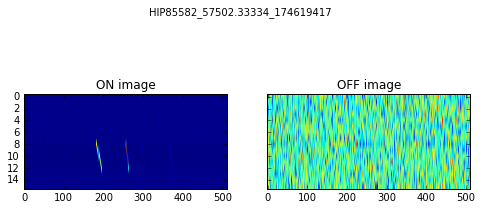

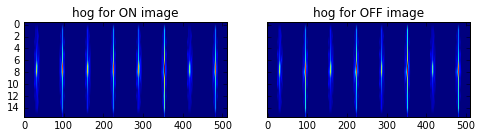

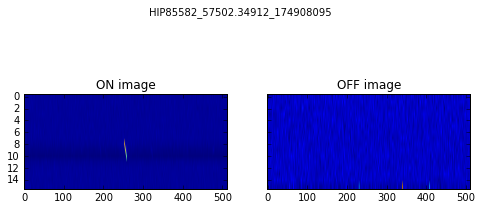

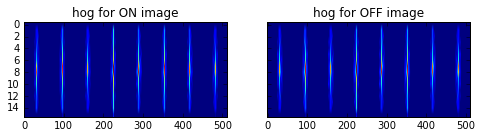

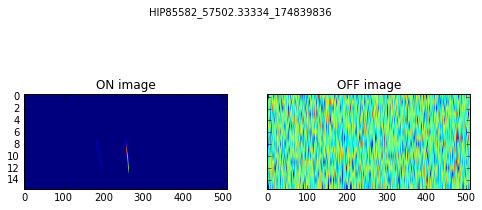

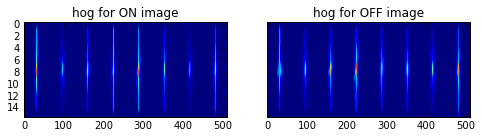

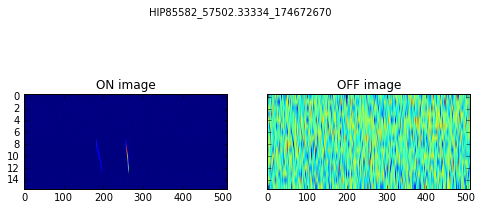

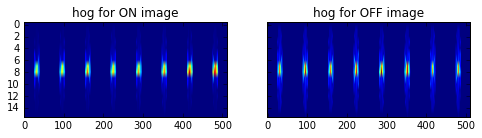

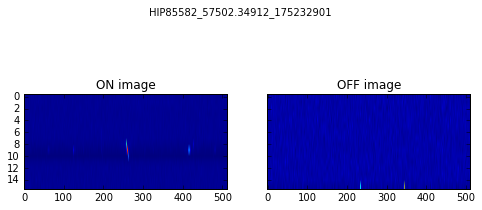

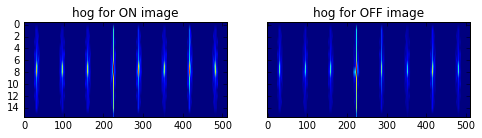

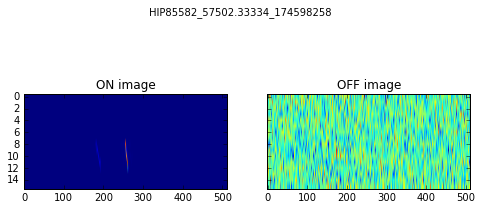

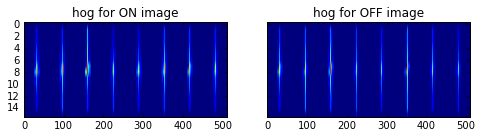

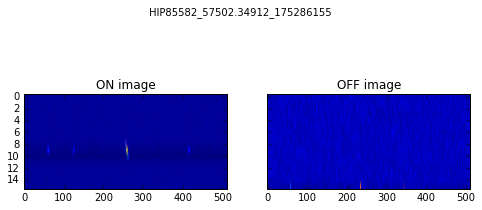

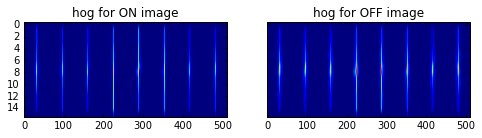

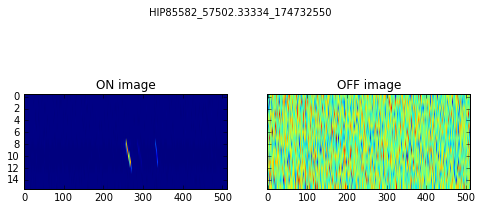

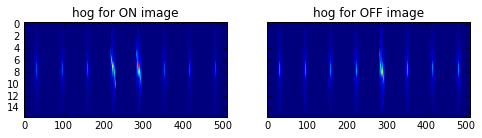

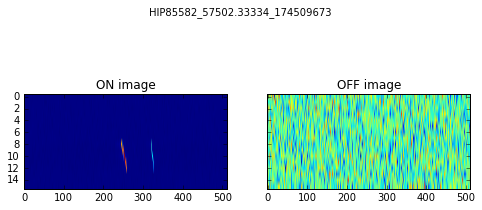

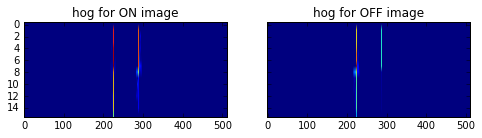

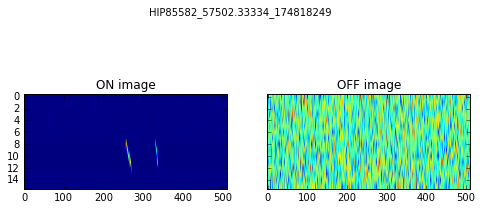

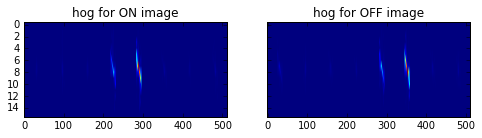

In [50]:
plot_hog(10)

In [51]:
pcc_table(inds[:10])

a_freq_c a_global a_nmi a_prmi a_spatial a_ssim a_time_c
-------- -------- ----- ------ --------- ------ --------
   -0.03     0.04  0.05   0.12      0.00   0.01    -0.07
   -0.12     0.02  0.01   0.08     -0.00   0.54     0.00
   -0.01     0.03  0.06   0.11      0.00   0.00    -0.17
   -0.05     0.03  0.03   0.09     -0.00   0.01     0.01
    0.01     0.01  0.01   0.09     -0.00   0.71    -0.01
   -0.02     0.03  0.06   0.13      0.00   0.00    -0.21
    0.00     0.02  0.01   0.09      0.00   0.58     0.00
   -0.05     0.03  0.04   0.10     -0.01   0.01     0.12
   -0.02     0.04  0.03   0.09      0.00   0.01    -0.16
   -0.05     0.02  0.03   0.11      0.00   0.01    -0.05
